In [114]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import openturns as ot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

# NASA Aluminium dataset
We could imitate the multifidelity setting by training different regression models.
Start with the feature extraction on the training dataset, use therefore T1-6 at different times to extract amplitude change, phase angle change, correlation coefficient change, as is done in the paper by Peng et. al 2014. 

## Feature extraction

In [294]:
# Load data copied from the excel tables
cycles_t1 = [50000, 60000, 62500, 65500, 69025, 70026, 70766]
crack_size_t1 = [0, 2.18, 2.76, 3.51, 4.51, 4.9, 7.46]

cycles_t2 = [50000, 70033, 72000]
crack_size_t2 = [0, 3.25, 4.95]

cycles_t3 = [14000, 50000, 57038, 60035, 62017, 64019, 65029, 66012, 66510]
crack_size_t3 = [0, 0, 2.57, 4.02, 4.72, 5.49, 5.9, 6.52, 6.93]

cycles_t4 = [55900, 60200, 65001, 67054, 70016, 71130, 73210, 75045]
crack_size_t4 = [0, 1.61, 2.17, 2.74, 3.13, 4.06, 4.96, 7.24]

cycles_t5 = [42000, 46000, 51000, 56000]
crack_size_t5 = [0, 0, 2.7, 3.64]


In [295]:
T1 = {cycles_t1[i]: {'crack_size': crack_size_t1[i]} for i in range(len(cycles_t1))}
T2 = {cycles_t2[i]: {'crack_size': crack_size_t2[i]} for i in range(len(cycles_t2))}
T3 = {cycles_t3[i]: {'crack_size': crack_size_t3[i]} for i in range(len(cycles_t3))}
T4 = {cycles_t4[i]: {'crack_size': crack_size_t4[i]} for i in range(len(cycles_t4))}
T5 = {cycles_t5[i]: {'crack_size': crack_size_t5[i]} for i in range(len(cycles_t5))}

In [296]:
train_data = [T1, T2, T3, T4, T5]

In [297]:
BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/NASA_crack_growth_data/'

In [298]:
for i in range(len(train_data)):
    for j in range(len(train_data[i].keys())):
        try:
            csv_file = BASE_DIRECTORY + f'training/T{(i+1)}/' +  str(list(train_data[i].keys())[j]) + '/signal_1.csv'
            train_data[i][list(train_data[i].keys())[j]]['signal1'] = pd.read_csv(csv_file)
        except:
            pass

In [299]:
fs = 200 #Hz

IndexError: list index out of range

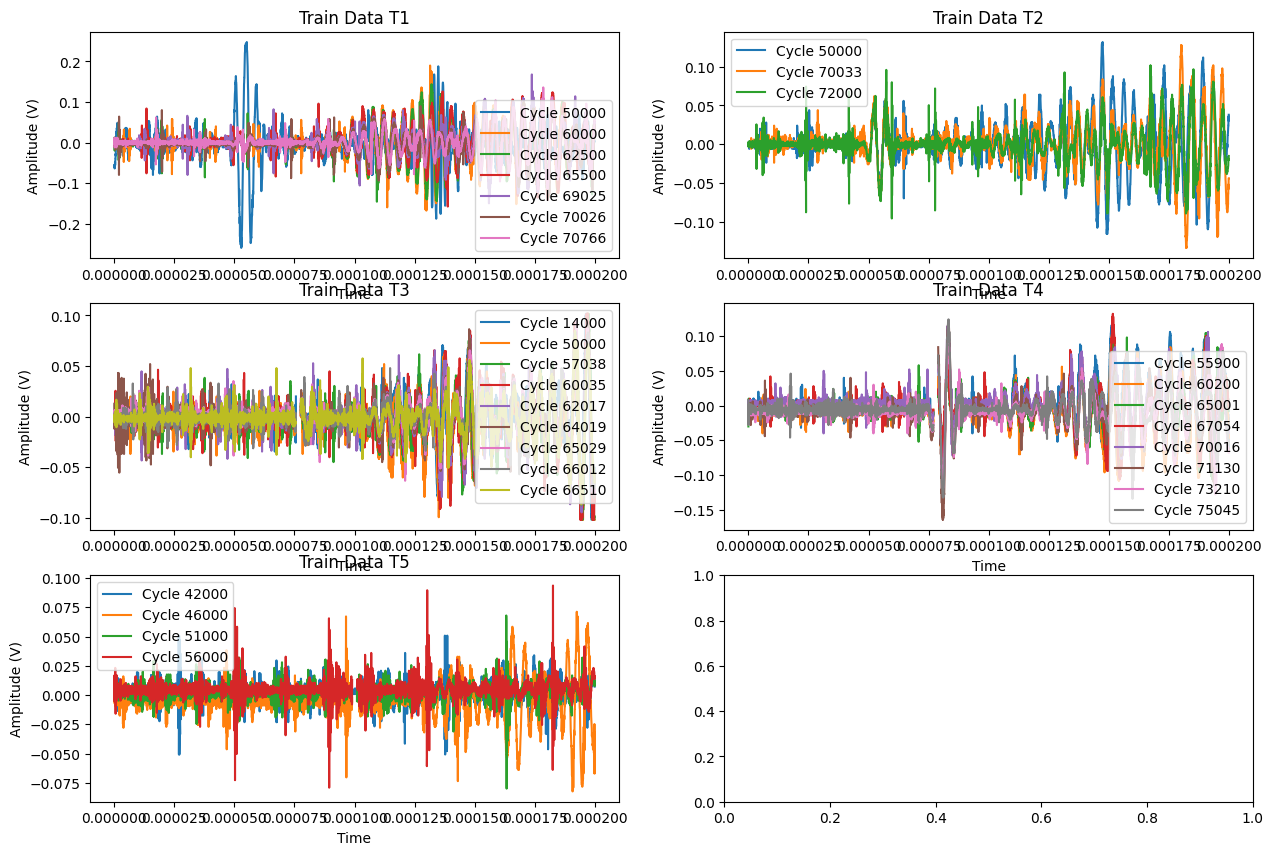

In [300]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Filter the signal

for i, ax in enumerate(axs.flatten()):
    for cycle, data in train_data[i].items():
        if 'signal1' in data:
            ax.plot(data['signal1']['time'],data['signal1']['ch2'], label=f'Cycle {cycle}')
    ax.set_title(f'Train Data T{i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude (V)')
    #ax.set_xlim(105e-6, 125e-6)
    ax.legend()

plt.tight_layout()
plt.show()

In [301]:
# Extract the time values from the signal
time_values = data['signal1']['time'].values

# Calculate the time difference between consecutive samples
time_diff = np.diff(time_values)

# Calculate the sampling frequency
sampling_frequency = 1 / np.mean(time_diff)
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: nan Hz


In [302]:
freq = 200e3  # 200 kHz central frequency
fs = 200e3

In [303]:
# 1. Amplitude Change Extraction
def extract_amplitude_change(baseline, damaged):
    """Computes the normalized amplitude change."""
    env_baseline = np.abs(signal.hilbert(baseline))
    env_damaged = np.abs(signal.hilbert(damaged))
    amplitude_norm = np.mean(env_damaged) / np.mean(env_baseline)
    amplitude_change = 1 - amplitude_norm
    return amplitude_change

# 2. Phase Change Extraction
def extract_phase_change(baseline, damaged):
    """Computes phase shift using cross-correlation."""
    corr = signal.correlate(damaged, baseline, mode='full')
    shift = np.argmax(corr) - len(baseline)  # Find the peak shift
    phase_change = shift / fs * 360 * freq  # Convert to degrees
    return phase_change

# 3. Correlation Coefficient Change Extraction
def extract_correlation_change(baseline, damaged):
    """Computes the correlation coefficient between baseline and damaged signals."""
    correlation_coeff = np.corrcoef(baseline, damaged)[0, 1]
    return correlation_coeff


In [304]:
for i in range(len(train_data)):
    baseline_signal = train_data[i][list(train_data[i].keys())[0]]['signal1']['ch2'].values

    train_data[i][list(train_data[i].keys())[0]]['amplitude_change'] = 0
    train_data[i][list(train_data[i].keys())[0]]['phase_change'] = 0
    train_data[i][list(train_data[i].keys())[0]]['correlation_change'] = 0
    
    for j in range(len(train_data[i].keys())-1):
        damaged_signal = train_data[i][list(train_data[i].keys())[j+1]]['signal1']['ch2'].values

        amplitude_change = extract_amplitude_change(baseline_signal, damaged_signal)
        phase_change = extract_phase_change(baseline_signal, damaged_signal)
        correlation_change = extract_correlation_change(baseline_signal, damaged_signal)

        print(f"Amplitude Change: {amplitude_change}")
        print(f"Phase Change: {phase_change}")
        print(f"Correlation Change: {correlation_change}")

        train_data[i][list(train_data[i].keys())[j+1]]['amplitude_change'] = amplitude_change
        train_data[i][list(train_data[i].keys())[j+1]]['phase_change'] = phase_change
        train_data[i][list(train_data[i].keys())[j+1]]['correlation_change'] = correlation_change

Amplitude Change: -0.07881869894703719
Phase Change: 554400.0
Correlation Change: -0.07071919981273783
Amplitude Change: -0.030084161534794207
Phase Change: 555840.0
Correlation Change: -0.06648296510513747
Amplitude Change: -0.023644530545420706
Phase Change: 919440.0
Correlation Change: -0.0653767744668491
Amplitude Change: 0.15331601476562384
Phase Change: 888480.0
Correlation Change: -0.061975169162460646
Amplitude Change: 0.25274711286773477
Phase Change: 889560.0
Correlation Change: -0.07606170179140363
Amplitude Change: 0.3283574543602793
Phase Change: 918000.0
Correlation Change: -0.1023311346439405
Amplitude Change: 0.1277150106285695
Phase Change: 1080.0
Correlation Change: 0.5320574463793943
Amplitude Change: 0.29115149409640095
Phase Change: 1440.0000000000002
Correlation Change: 0.4950727086975983
Amplitude Change: -0.1887829063343507
Phase Change: 2519.9999999999995
Correlation Change: 0.7123176379993109
Amplitude Change: -0.19160801137004446
Phase Change: 3600.0000000000

In [350]:
#Normalize the features
scaler = MinMaxScaler()
X_train = np.array([[train_data[i][key]['amplitude_change'], train_data[i][key]['phase_change'], train_data[i][key]['correlation_change']] for i in range(len(train_data)) for key in train_data[i].keys()])
X_train = scaler.fit_transform(X_train)

In [351]:
y_train = np.asarray([train_data[i][key]['crack_size'] for i in range(len(train_data)) for key in train_data[i].keys()])

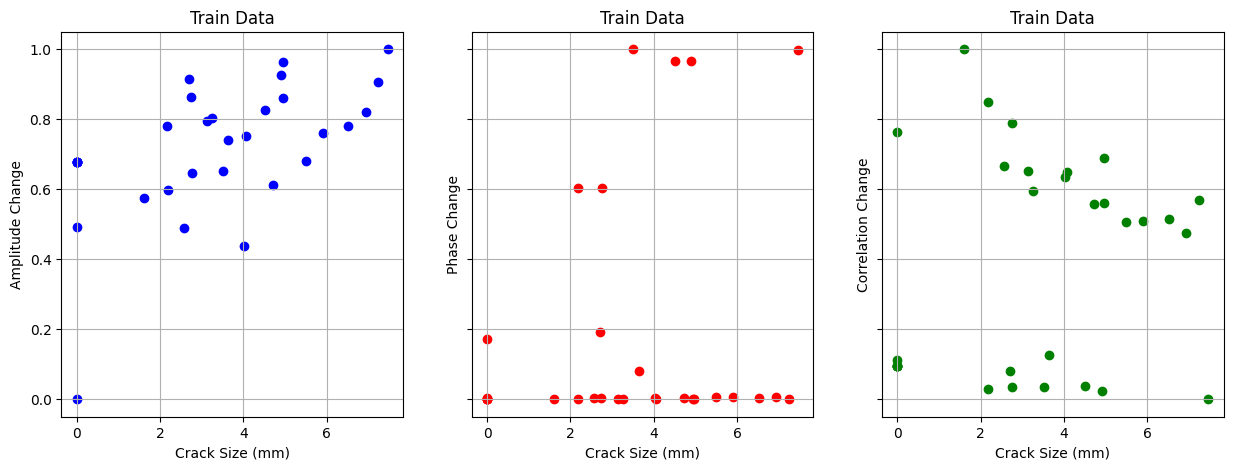

In [352]:
# Display the extracted features correlation with the crack size
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].scatter(y_train, X_train[:, 0], color='blue')
axs[0].set_xlabel('Crack Size (mm)')
axs[0].set_ylabel('Amplitude Change')
axs[0].set_title(f'Train Data')
axs[0].grid(True)

axs[1].scatter(y_train,  X_train[:, 1], color='red')
axs[1].set_xlabel('Crack Size (mm)')
axs[1].set_ylabel('Phase Change')
axs[1].set_title(f'Train Data')
axs[1].grid(True)

axs[2].scatter(y_train,  X_train[:, 2], color='green')
axs[2].set_xlabel('Crack Size (mm)')
axs[2].set_ylabel('Correlation Change')
axs[2].set_title(f'Train Data')
axs[2].grid(True)    

## Validation set

In [326]:
# Validation data
cycles_t6 = [55000, 60078, 68091, 69018, 72516, 73211]
crack_size_t6 = [0, 0.82, 2.36, 3.36, 4.65, 5.08]

cycles_t7 = [36001, 40167, 44054, 47022]
crack_size_t7 = [0, 2.07, 3.14, 3.56]


In [327]:
T6 = {cycles_t6[i]: {'crack_size': crack_size_t6[i]} for i in range(len(cycles_t6))}
T7 = {cycles_t7[i]: {'crack_size': crack_size_t7[i]} for i in range(len(cycles_t7))}

In [328]:
validation_data = [T6, T7]

In [329]:
for i in range(len(validation_data)):
    for j in range(len(validation_data[i].keys())):
        try:
            csv_file = BASE_DIRECTORY + f'validation/T{(i+6)}/' +  str(list(validation_data[i].keys())[j]) + '/signal_1.csv'
            validation_data[i][list(validation_data[i].keys())[j]]['signal1'] = pd.read_csv(csv_file)
        except:
            pass

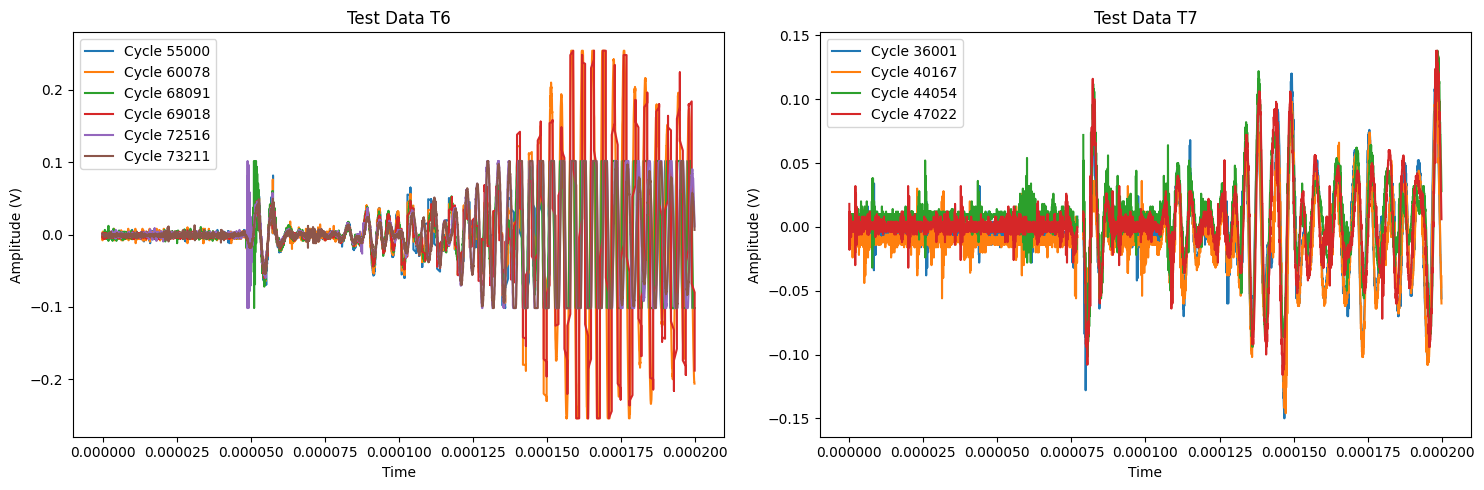

In [330]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Filter the signal

for i, ax in enumerate(axs.flatten()):
    for cycle, data in validation_data[i].items():
        if 'signal1' in data:
            ax.plot(data['signal1']['time'],data['signal1']['ch2'], label=f'Cycle {cycle}')
    ax.set_title(f'Test Data T{i+6}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude (V)')
    #ax.set_xlim(105e-6, 125e-6)
    ax.legend()

plt.tight_layout()
plt.show()

In [331]:
for i in range(len(validation_data)):
    baseline_signal = validation_data[i][list(validation_data[i].keys())[0]]['signal1']['ch2'].values

    validation_data[i][list(validation_data[i].keys())[0]]['amplitude_change'] = 0
    validation_data[i][list(validation_data[i].keys())[0]]['phase_change'] = 0
    validation_data[i][list(validation_data[i].keys())[0]]['correlation_change'] = 0

    
    for j in range(len(validation_data[i].keys())-1):
        damaged_signal = validation_data[i][list(validation_data[i].keys())[j+1]]['signal1']['ch2'].values

        amplitude_change = extract_amplitude_change(baseline_signal, damaged_signal)
        phase_change = extract_phase_change(baseline_signal, damaged_signal)
        correlation_change = extract_correlation_change(baseline_signal, damaged_signal)

        print(f"Amplitude Change: {amplitude_change}")
        print(f"Phase Change: {phase_change}")
        print(f"Correlation Change: {correlation_change}")

        validation_data[i][list(validation_data[i].keys())[j+1]]['amplitude_change'] = amplitude_change
        validation_data[i][list(validation_data[i].keys())[j+1]]['phase_change'] = phase_change
        validation_data[i][list(validation_data[i].keys())[j+1]]['correlation_change'] = correlation_change

Amplitude Change: -0.49189708351094663
Phase Change: 0.0
Correlation Change: 0.9305126450718956
Amplitude Change: 0.016909393308926712
Phase Change: 720.0000000000001
Correlation Change: 0.8544070693740471
Amplitude Change: -0.4173640080834704
Phase Change: 1800.0000000000002
Correlation Change: 0.747803474299745
Amplitude Change: -0.0009233325669031345
Phase Change: -150840.0
Correlation Change: 0.13723691872737592
Amplitude Change: 0.08256511675436051
Phase Change: -150480.0
Correlation Change: 0.0852428943920519
Amplitude Change: -0.022226009083535114
Phase Change: 0.0
Correlation Change: 0.9471614026806071
Amplitude Change: 0.04579980441350495
Phase Change: 1080.0
Correlation Change: 0.7226575266193133
Amplitude Change: 0.05776427089243841
Phase Change: 360.00000000000006
Correlation Change: 0.7219880196228206


In [332]:
#Normalize the features
scaler = StandardScaler()
X_test = np.array([[validation_data[i][key]['amplitude_change'], validation_data[i][key]['phase_change'], validation_data[i][key]['correlation_change']] for i in range(len(validation_data)) for key in validation_data[i].keys()])
X_test = scaler.fit_transform(X_test)

In [333]:
y_test = np.asarray([validation_data[i][key]['crack_size'] for i in range(len(validation_data)) for key in validation_data[i].keys()])

In [334]:
y_test

array([0.  , 0.82, 2.36, 3.36, 4.65, 5.08, 0.  , 2.07, 3.14, 3.56])

In [338]:
X_test

array([[ 0.3761502 ,  0.49179179, -1.34124988],
       [-2.16065164,  0.49179179,  1.08355595],
       [ 0.46335498,  0.50369958,  0.88523383],
       [-1.77627115,  0.52156127,  0.60743747],
       [ 0.3713884 , -2.00289054, -0.98362671],
       [ 0.80195337, -1.99693664, -1.11911698],
       [ 0.3761502 ,  0.49179179, -1.34124988],
       [ 0.26152666,  0.49179179,  1.12694064],
       [ 0.61234803,  0.50965348,  0.54191011],
       [ 0.67405094,  0.49774569,  0.54016545]])

## Linear model

In [335]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [339]:
model.coef_

array([1.09827112, 0.89619237, 0.94533336])